# Tracking Congress Members' Tweets Sentiment

In [120]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import re
plt.style.use('seaborn')
import dill
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
import re
from textblob import TextBlob
import preprocessor as p

In [121]:
# load the data
df = dill.load(open('tweets.pkd', 'rb'))

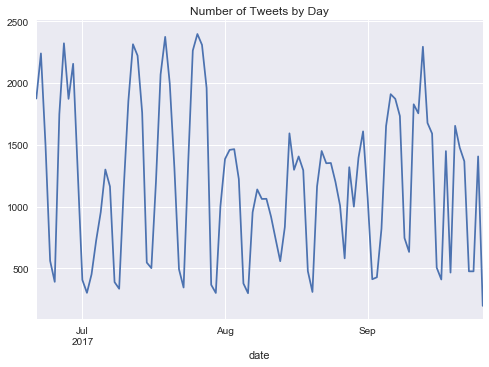

In [122]:
df.text.resample('D').count().plot()
plt.title('Number of Tweets by Day');
plt.savefig('tweets.pdf', dpi=600)

In [123]:
# pre-process tweets
import random
values = list(range(100000))

In [124]:
v = random.choice(values)

p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.RESERVED, p.OPT.MENTION, p.OPT.NUMBER, p.OPT.SMILEY)
#print(df.text[v])
# print(p.clean(df.text[v]))

In [125]:
ptweets = [p.clean(text) for text in df.text]

In [126]:
def clean_tweets(text):
    text = re.sub(r'\&amp\;', 'and', text)
    text = re.sub(r'QT|GT|gt', ' ', text)
    return text

In [127]:
ptweets = [clean_tweets(text) for text in ptweets]

In [128]:
# len(ptweets)

In [129]:
# def get_tweet_sentiment(tweet):
#     analysis = TextBlob(clean_tweet(tweet))
#     return analysis.sentiment.polarity

In [130]:
tb = [TextBlob(i) for i in ptweets]
polarity = [i.polarity for i in tb]
subjectivity = [i.subjectivity for i in tb]

# add scores to data frame
df['polarity'] = polarity
df['subjectivity'] = subjectivity

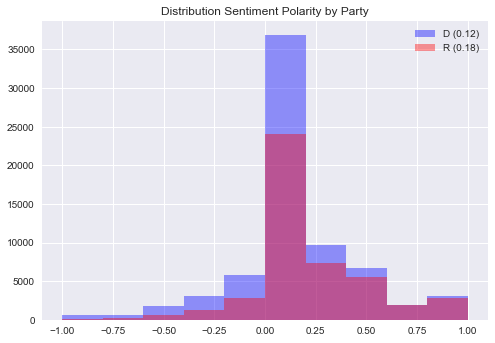

In [131]:
# plots
plt.hist(df.loc[df.party=='D', 'polarity'].reset_index(drop=True), alpha=0.4, color='blue', bins=10,label="Democrat")
plt.hist(df.loc[df.party=='R', 'polarity'].reset_index(drop=True), alpha=0.4, color='red',bins=10, label="Republican")

plt.title('Distribution Sentiment Polarity by Party')
d = 'D (%3.2f)' %df.loc[df.party=='D', 'polarity'].mean()
r = 'R (%3.2f)' %df.loc[df.party=='R', 'polarity'].mean()
plt.legend(labels=[d, r]);

plt.savefig('sentiment_dist.pdf', dpi=600)

In [132]:
# plt.hist(df.loc[df.party=='D', 'subjectivity'].reset_index(drop=True), alpha=0.4, color='blue', bins=10,label="Democrat")
# plt.hist(df.loc[df.party=='R', 'subjectivity'].reset_index(drop=True), alpha=0.4, color='red',bins=10, label="Republican")

# plt.title('Distribution Subjectivity by Party')
# d = 'D (%3.2f)' %df.loc[df.party=='D', 'subjectivity'].mean()
# r = 'R (%3.2f)' %df.loc[df.party=='R', 'subjectivity'].mean()
# plt.legend(labels=[d, r]);

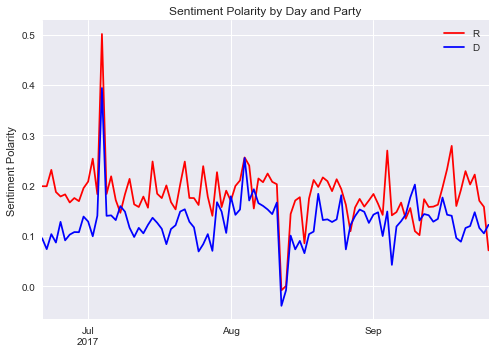

In [133]:
# plot lines by party

ax1 = df.loc[df.party=='R', 'polarity'].resample('D').mean().plot(color='red');
ax2 = df.loc[df.party=='D', 'polarity'].resample('D').mean().plot(color='blue');
plt.legend(labels=['R', 'D'])

ax1.set_xlabel('')
ax1.set_ylabel('Sentiment Polarity')
ax1.set_title('Sentiment Polarity by Day and Party');

plt.savefig('sentiment_day.pdf', dpi=600)

In [134]:
# create plot using bokeh
# pending

# Topic Modeling

## NMF


In [135]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [136]:
# NMF is able to use tf-idf
no_features = 1000
no_topics = 20
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(ptweets)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [137]:
# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

In [138]:
# def display_topics(model, feature_names, no_top_words):
#     for topic_idx, topic in enumerate(model.components_):
#         print("Topic %d:" % (topic_idx))
#         print(" ".join([feature_names[i]
#                         for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [139]:
def get_words_by_topic(model, feature_names, no_top_words = 8):
    words = []
    for topic_idx, topic in enumerate(model.components_):
        words.append(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
    return(words)

In [140]:
def get_topic_by_doc(model, tfidf):
    doc_topic_distrib = model.transform(tfidf)
    topics = []
    for i in doc_topic_distrib:
        topics.append(i.argmax())
    return topics

In [141]:
words = get_words_by_topic(nmf, tfidf_feature_names)

In [142]:
df['topic_nmf'] = get_topic_by_doc(nmf, tfidf)
#df.topic_nmf.value_counts()

In [143]:
dp = df.loc[df.party.isin(['R', 'D']), ['topic_nmf', 'party', 'polarity']].groupby(['topic_nmf', 'party']).mean()
dp.reset_index(inplace=True)
dp = dp.pivot_table(values='polarity', index=['topic_nmf'], columns='party')
dp.reset_index(inplace=True)

# get words
dp['words'] = words
dp['diff'] = np.abs(dp.R - dp.D)
dp = dp.sort_values(by='diff', ascending=True)

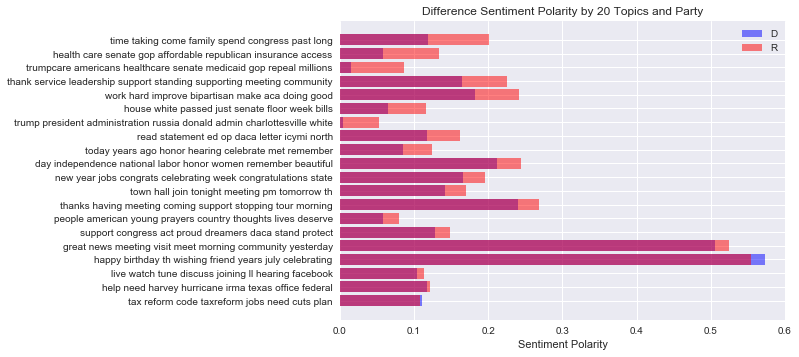

In [144]:
# plot 

objects= dp.words.values
pos = np.arange(len(objects))
D = dp.D.values
R = dp.R.values

plt.barh(pos, D, align='center', alpha=0.5, color ='blue')
plt.yticks(pos, objects)
plt.xlabel('Sentiment Polarity')
plt.title('Difference Sentiment Polarity by 20 Topics and Party')

plt.barh(pos, R, align='center', alpha=0.5, color = 'red')
plt.legend(labels=['D', 'R']);

plt.savefig('nmf.pdf', dpi=600, bbox_inches='tight');

# LDA

In [145]:
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
no_features = 1000
no_topics = 20
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(ptweets)
tf_feature_names = tf_vectorizer.get_feature_names()

In [146]:
# run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', 
                                learning_offset=50.,random_state=0).fit(tf)

In [147]:
words = get_words_by_topic(lda, tfidf_feature_names)
# words[0:10]

df['topic_lda'] = get_topic_by_doc(lda, tf)
#df.topic_nmf.value_counts()

In [148]:
dp = pd.DataFrame()
dp = df.loc[df.party.isin(['R', 'D']), ['topic_lda', 'party', 'polarity']].groupby(['topic_lda', 'party']).mean()
dp.reset_index(inplace=True)
dp = dp.pivot_table(values='polarity', index=['topic_lda'], columns='party')
dp.reset_index(inplace=True)

# get words
dp['words'] = words
dp['diff'] = np.abs(dp.R - dp.D)
dp = dp.sort_values(by='diff', ascending=True)

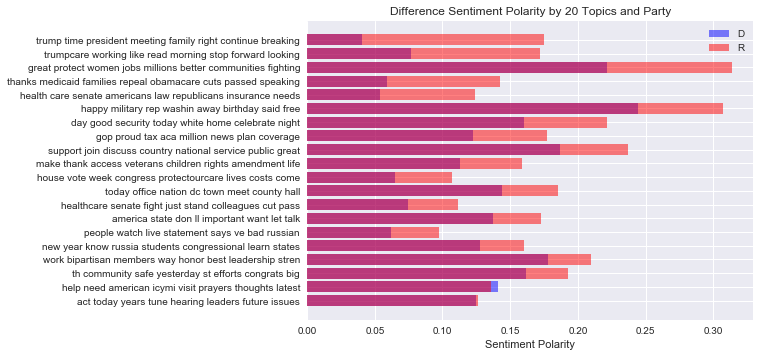

In [149]:
# plot

objects= dp.words.values
pos = np.arange(len(objects))
D = dp.D.values
R = dp.R.values

plt.barh(pos, D, align='center', alpha=0.5, color ='blue')
plt.yticks(pos, objects)
plt.xlabel('Sentiment Polarity')
plt.title('Difference Sentiment Polarity by 20 Topics and Party')

plt.barh(pos, R, align='center', alpha=0.5, color = 'red')
plt.legend(labels=['D', 'R']);
plt.savefig('lda.pdf', dpi=600, bbox_inches='tight');

# Other plots

In [150]:
# import lda
# from sklearn.feature_extraction.text import CountVectorizer

# n_topics = 20 # number of topics
# n_iter = 500 # number of iterations

# vectorizer: ignore English stopwords & words that occur less than 5 times
# cvectorizer = CountVectorizer(min_df=5, stop_words='english')
# cvz = cvectorizer.fit_transform(ptweets)

In [151]:
# train an LDA model
# lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter)
# X_topics = lda_model.fit_transform(cvz)

In [152]:
# topic_word = lda_model.components_  # model.components_ also works
# n_top_words = 5
# for i, topic_dist in enumerate(topic_word):
#     topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
#     print('Topic {}: {}'.format(i, ' '.join(topic_words)))

In [153]:
# doc_topic = lda_model.doc_topic_

In [154]:
# doc_topic = lda_model.doc_topic_

# topics = []
# for i in doc_topic:
#      topics.append(i.argmax())

In [155]:
# topic_word = lda_model.components_  # model.components_ also works
# n_top_words = 8

# words = []
# for i, topic_dist in enumerate(topic_word):
#     topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
#     words.append(' '.join(topic_words))

In [156]:
# words

In [157]:
# df['topic'] = topics

In [158]:
# barh(pos,val, align='center')
# yticks(pos, ('Tom', 'Dick', 'Harry', 'Slim', 'Jim'))
# xlabel('Performance')
# title('How fast do you want to go today?')
# grid(True)

# plt.bar(y_pos, R, align='center', alpha=0.5)
#
# plt.xticks(rotation=45)

# Fancy plot

In [159]:
# threshold = 0.5
# _idx = np.amax(X_topics, axis=1) > threshold  # idx of doc that above the threshold
# X_topics = X_topics[_idx]

In [160]:
# from sklearn.manifold import TSNE

# # a t-SNE model
# # angle value close to 1 means sacrificing accuracy for speed
# # pca initializtion usually leads to better results 
# tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')

# # 20-D -> 2-D
# tsne_lda = tsne_model.fit_transform(X_topics)

In [161]:
# import bokeh.plotting as bp
# from bokeh.plotting import save
# from bokeh.models import HoverTool

# n_top_words = 5 # number of keywords we show

# # 20 colors
# colormap = np.array([
#     "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
#     "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
#     "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
#     "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
# ])

In [162]:
# _lda_keys = []
# for i in range(X_topics.shape[0]):
#   _lda_keys +=  X_topics[i].argmax(),
# topic_summaries = []
# topic_word = lda_model.topic_word_  # all topic words
# vocab = cvectorizer.get_feature_names()

In [163]:
# for i, topic_dist in enumerate(topic_word):
#     topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words + 1):-1] # get!
#     topic_summaries.append(' '.join(topic_words)) # append!
# title = '20 Congress Membembers Tweets LDA viz'
# num_example = len(X_topics)

# plot_lda = bp.figure(plot_width=1400, plot_height=1100,
#                      title=title,
#                      tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
#                      x_axis_type=None, y_axis_type=None, min_border=1)

# plot_lda.scatter(x=tsne_lda[:, 0], y=tsne_lda[:, 1],
#                  color=colormap[_lda_keys][:num_example],
#                  source=bp.ColumnDataSource({
#                    "content": ptweets[:num_example],
#                    "topic_key": _lda_keys[:num_example]
#                    }))

In [164]:
# # randomly choose a news (within a topic) coordinate as the crucial words coordinate
# topic_coord = np.empty((X_topics.shape[1], 2)) * np.nan
# for topic_num in _lda_keys:
#   if not np.isnan(topic_coord).any():
#     break
#   topic_coord[toptopic_word = model.topic_word_  # model.components_ also works
# >>> n_top_words = 8
# >>> for i, topic_dist in enumerate(topic_word):
# ...     topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
# ...     print('Topic {}: {}'.format(i, ' '.join(topic_words)))ic_num] = tsne_lda[_lda_keys.index(topic_num)]

# # plot crucial words
# for i in range(X_topics.shape[1]):
#   plot_lda.text(topic_coord[i, 0], topic_coord[i, 1], [topic_summaries[i]])

# # hover tools
# hover = plot_lda.select(dict(type=HoverTool))
# hover.tooltips = {"content": "@content - topic: @topic_key"}

# # save the plot
# save(plot_lda, '{}.html'.format(title))